<a href="https://colab.research.google.com/github/mellalbuquerque/fashiondata/blob/main/Spring_2025_Ready_To_Wear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [1]:
# Importação de Bibliotecas

!pip install --upgrade fashion_words
from fashion_words import fashion_words

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import re
import unicodedata
import pandas as pd
import random


# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm") # Define the nlp variable by loading the language model

# Ajuste do tokenizer para preservar hífens
infixes = nlp.Defaults.infixes
infixes = [pattern for pattern in infixes if "-" not in pattern]
infix_re = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer



Retrieving data

In [2]:
df = pd.read_csv('corpus_spring2025_ready_to_wear.csv')
articles = df['text'].dropna().tolist()




---




📌 Gerando gráficos...


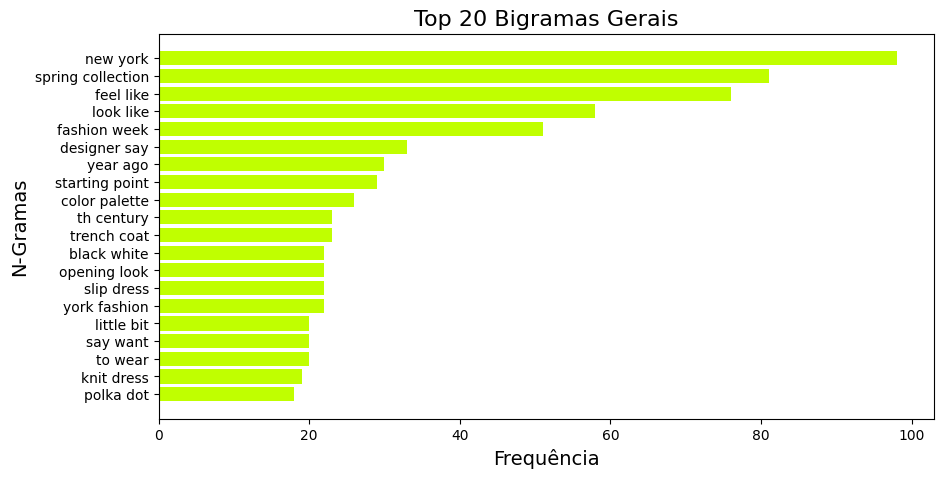

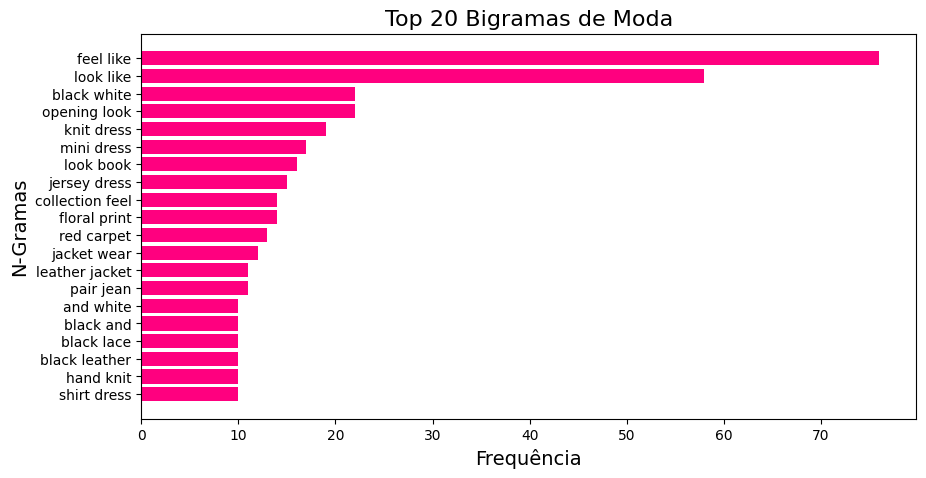

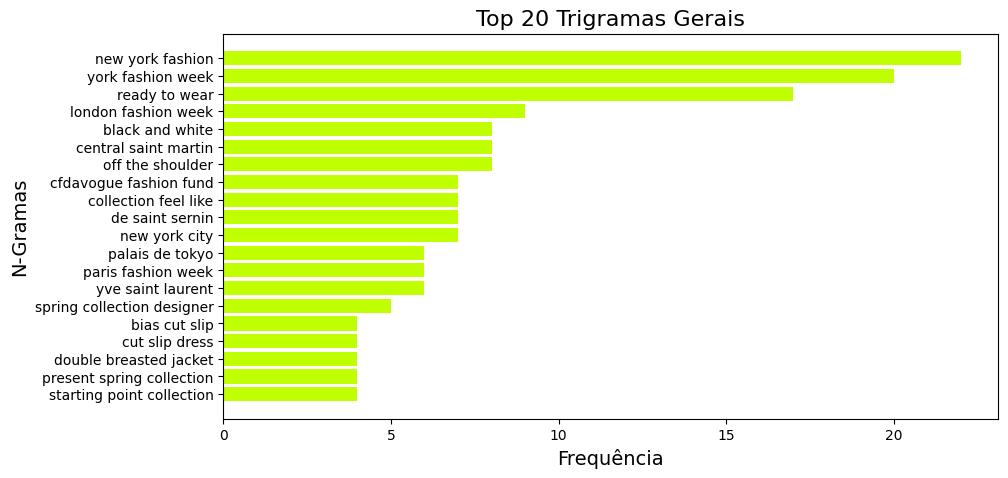

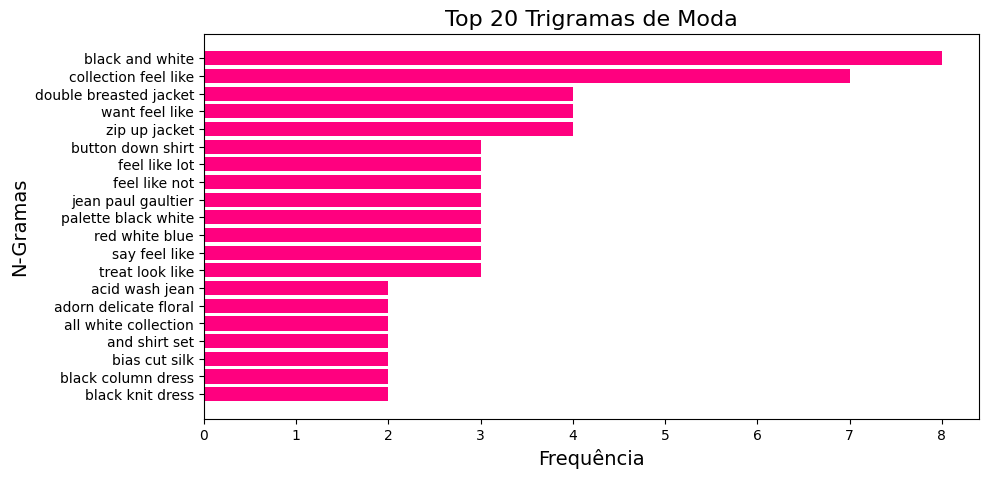


📌 Bigramas para silhouettes_and_fitting:


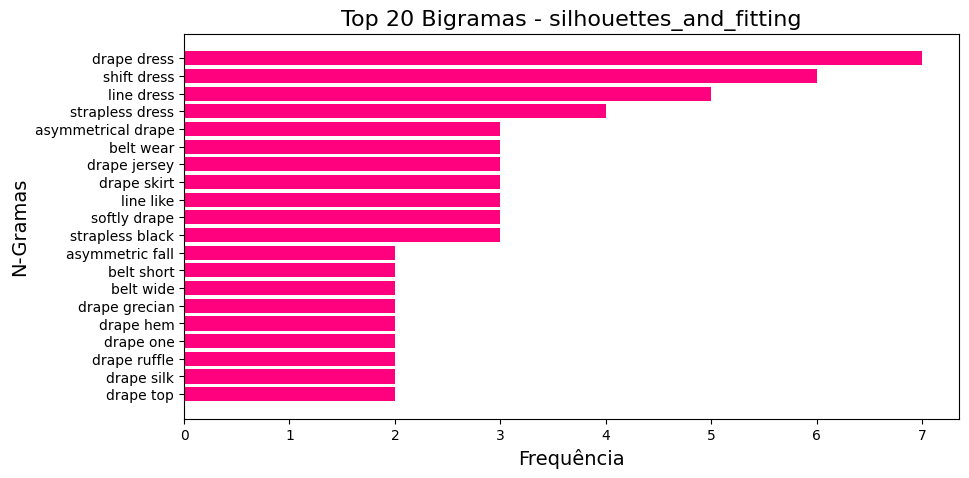


📌 Bigramas para techniques_and_finishes:


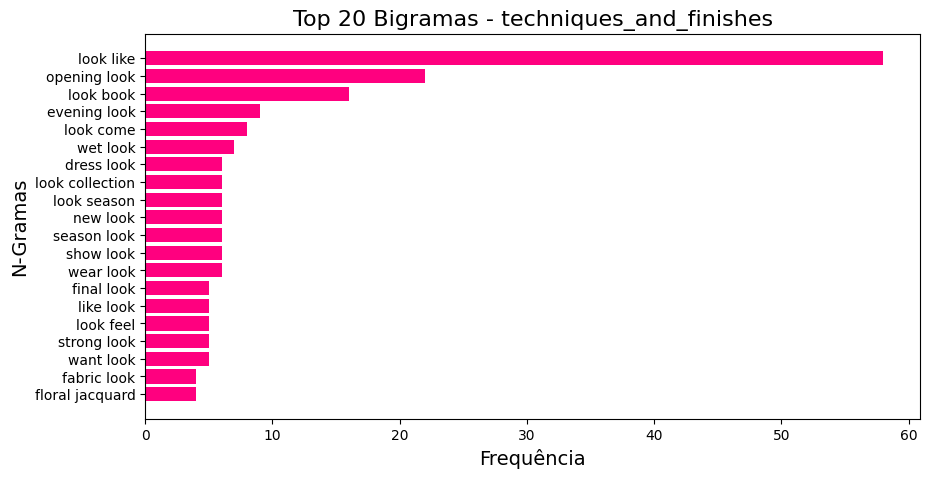


📌 Bigramas para garment_construction_and_components:


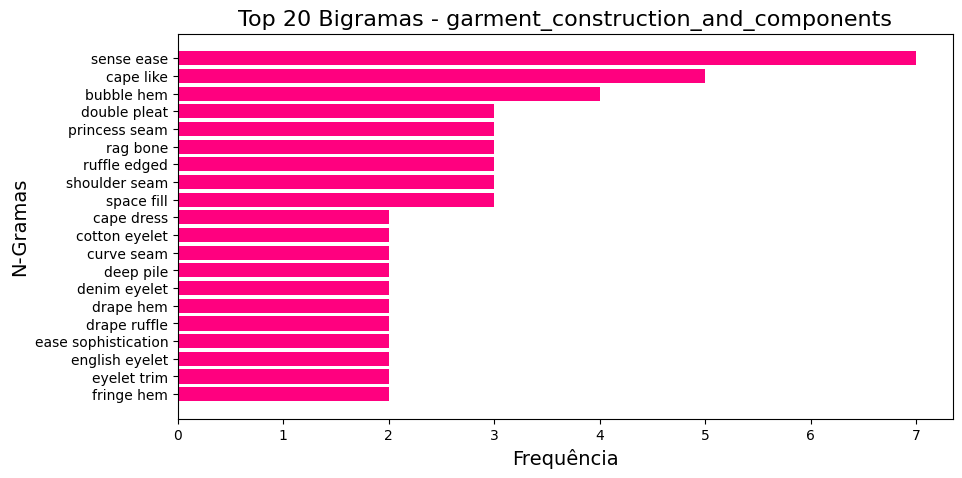


📌 Bigramas para accessories_and_bags:


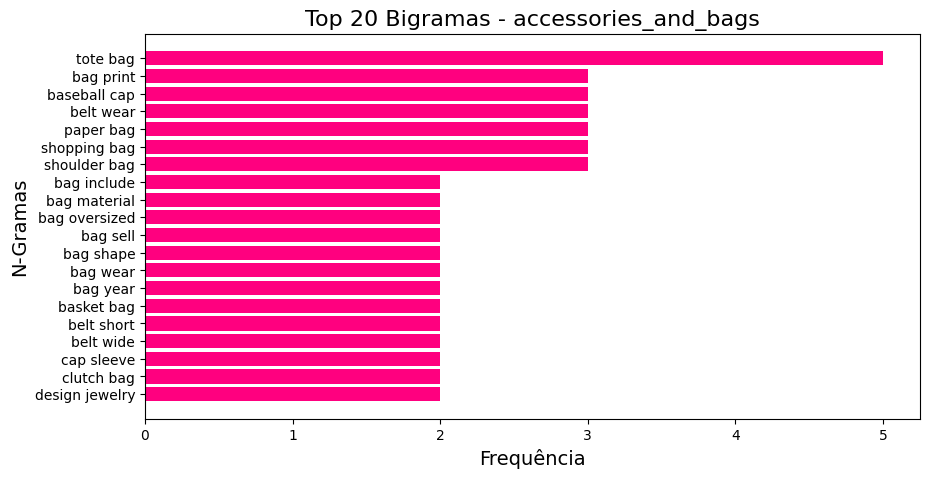


📌 Bigramas para footwear:


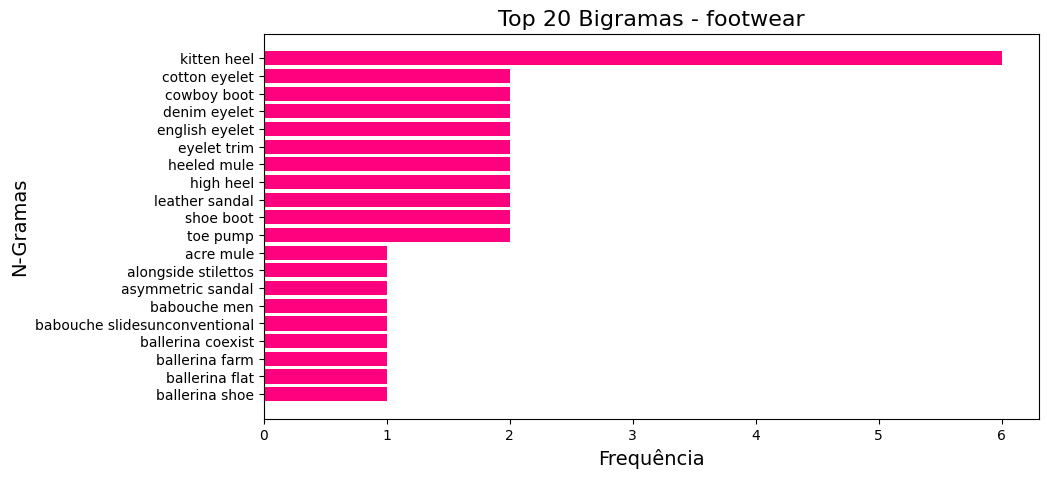


📌 Bigramas para clothing_pieces:


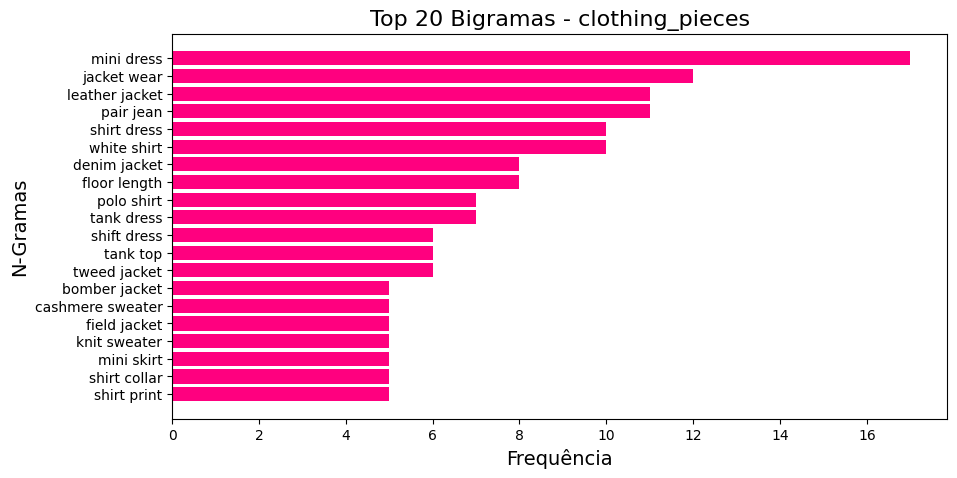


📌 Bigramas para fabrics:


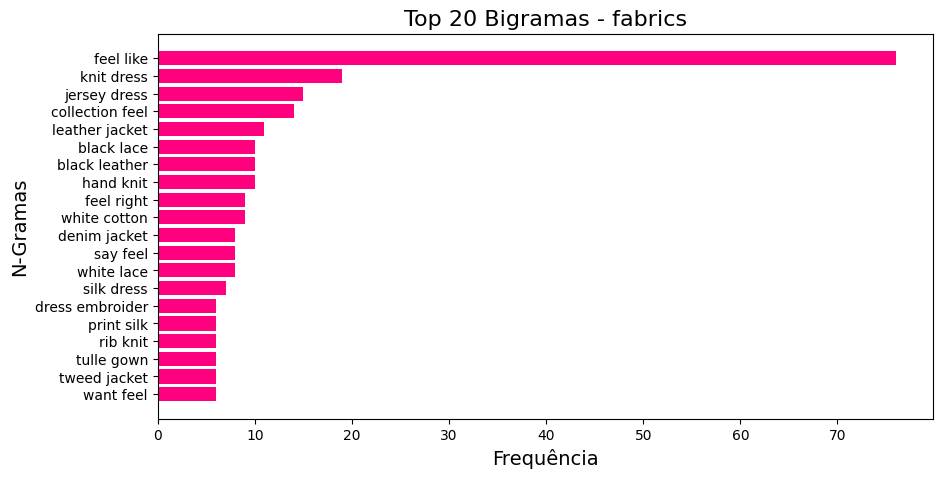


📌 Bigramas para styles:


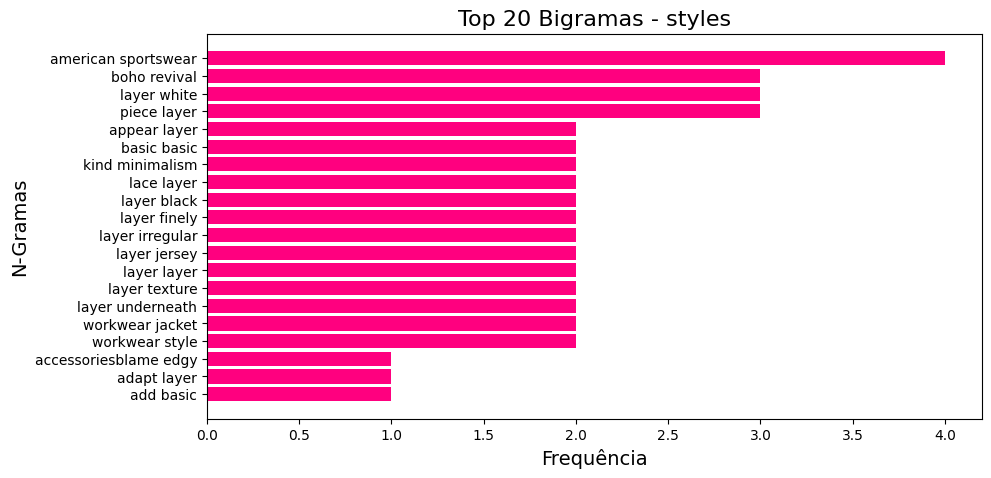


📌 Bigramas para patterns_and_prints:


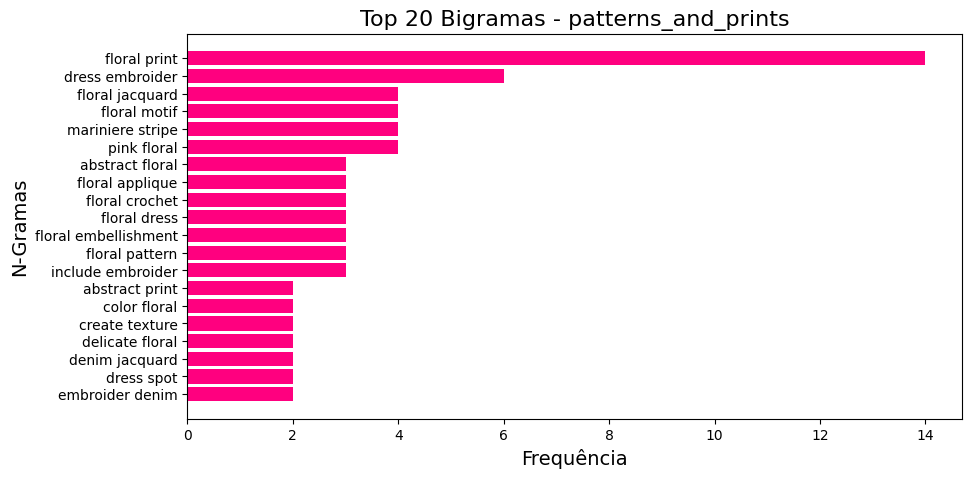


📌 Bigramas para colors:


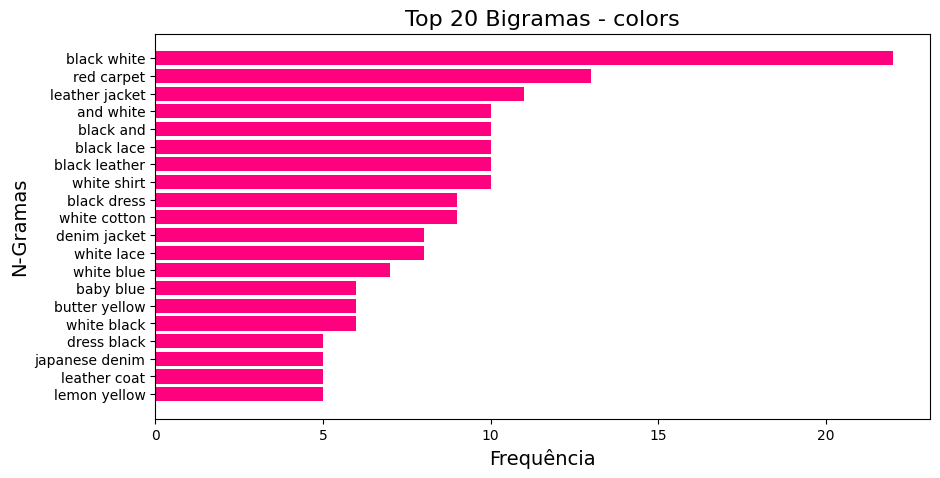


📌 Trigramas para silhouettes_and_fitting:


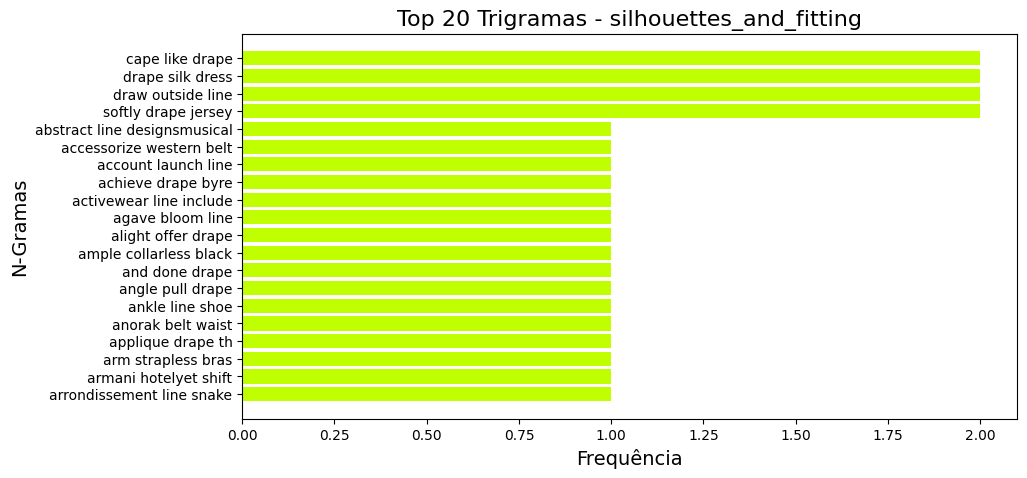


📌 Trigramas para techniques_and_finishes:


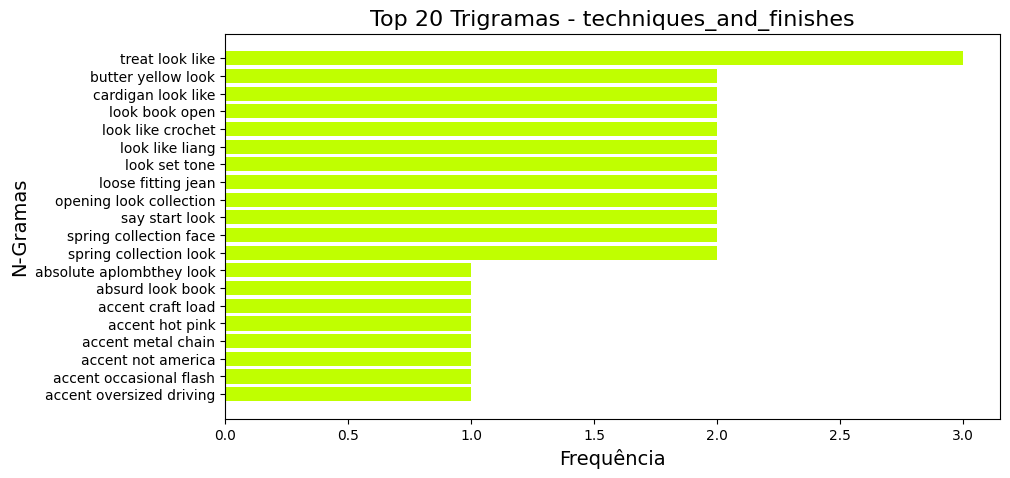


📌 Trigramas para garment_construction_and_components:


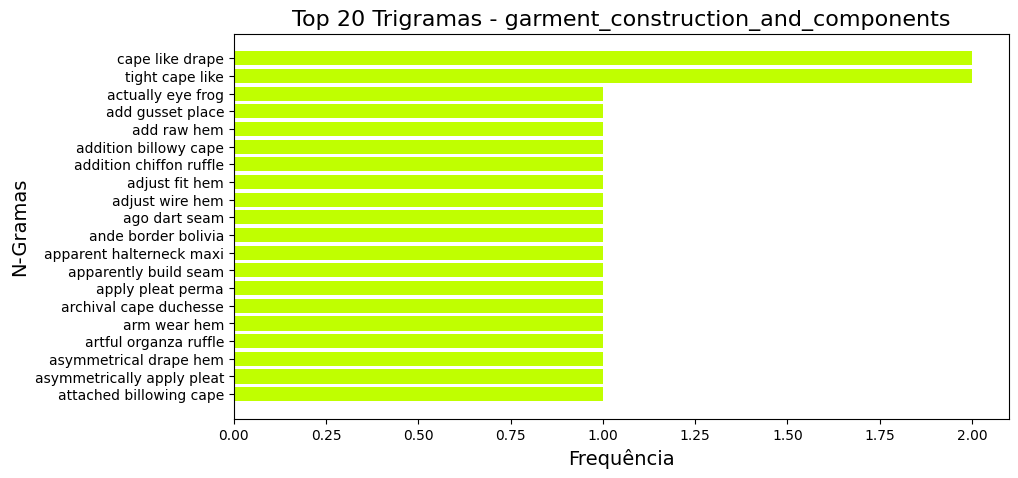


📌 Trigramas para accessories_and_bags:


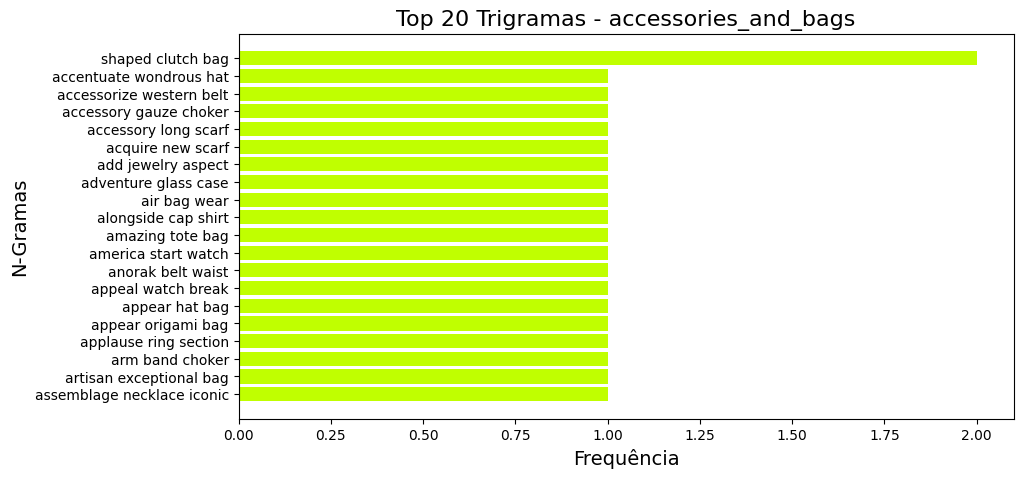


📌 Trigramas para footwear:


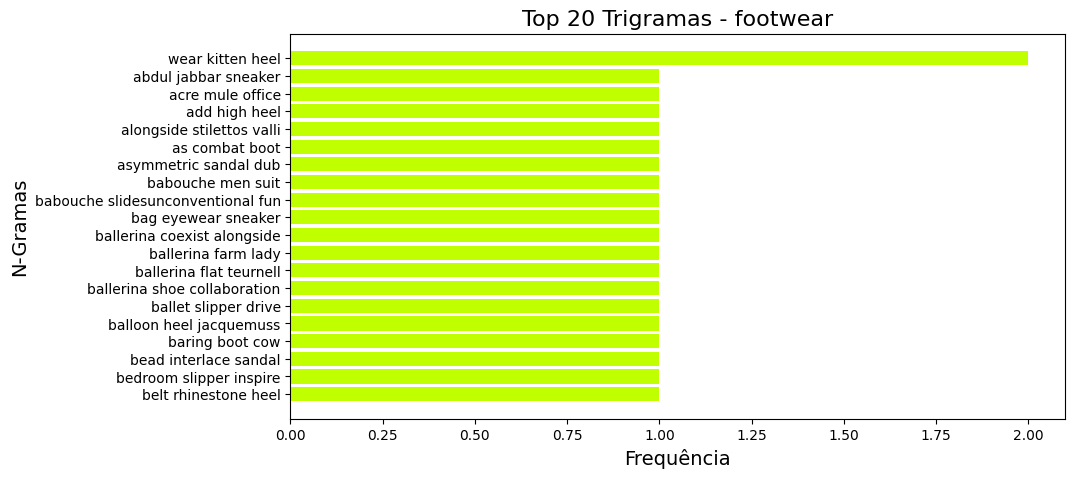


📌 Trigramas para clothing_pieces:


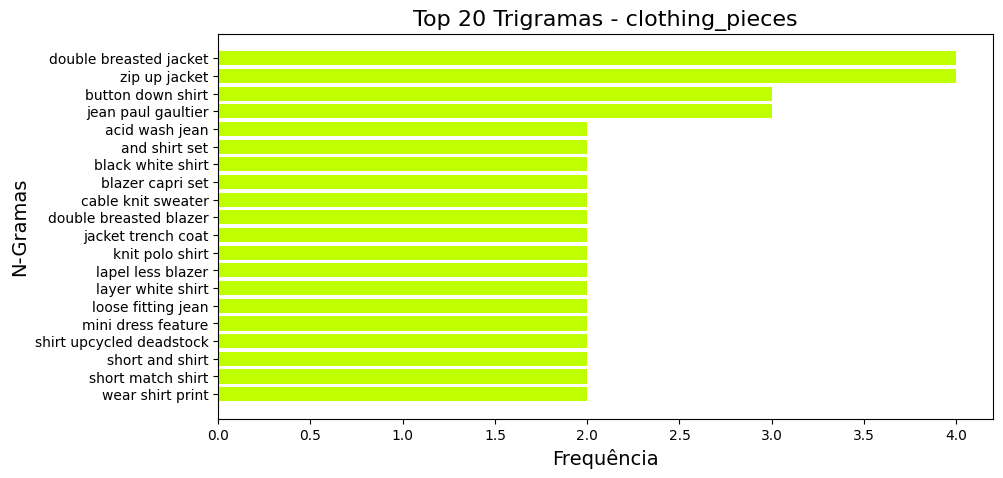


📌 Trigramas para fabrics:


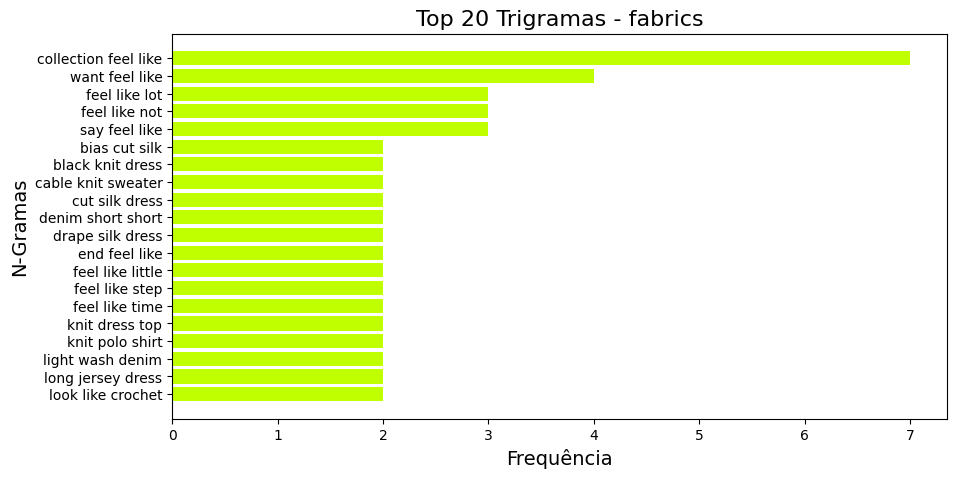


📌 Trigramas para styles:


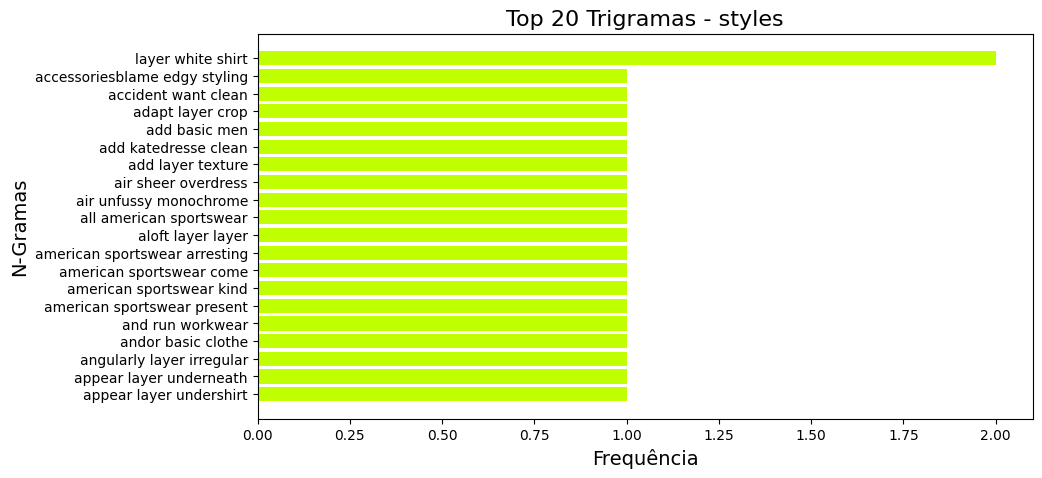


📌 Trigramas para patterns_and_prints:


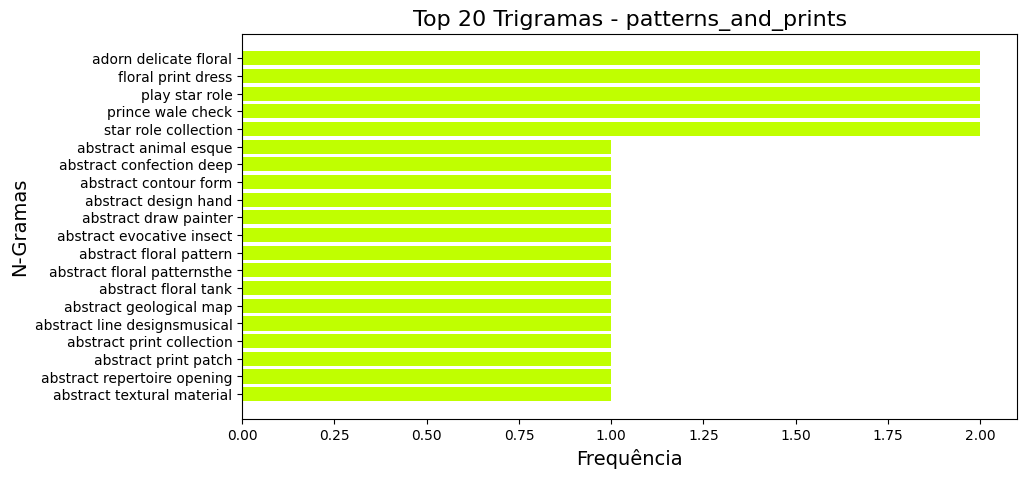


📌 Trigramas para colors:


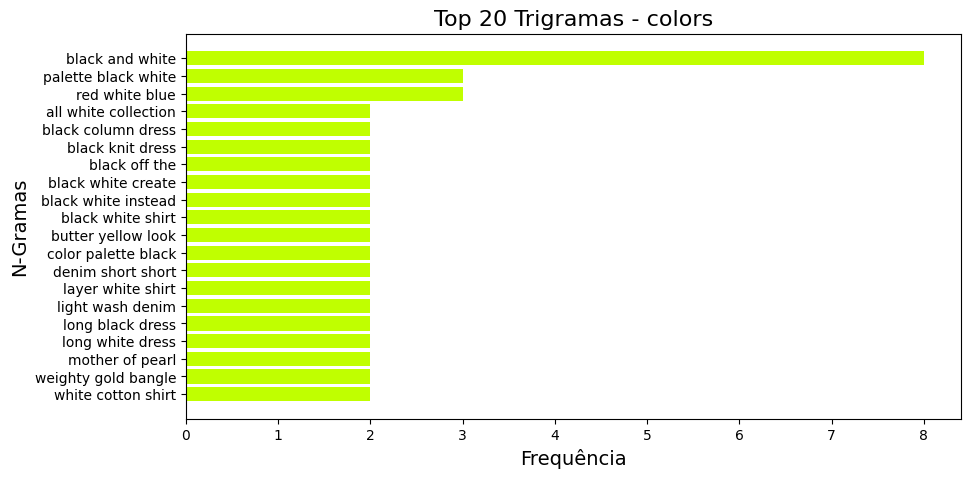

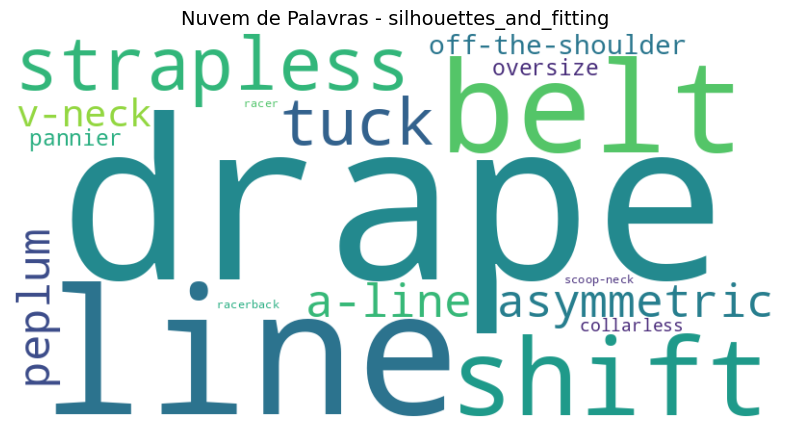

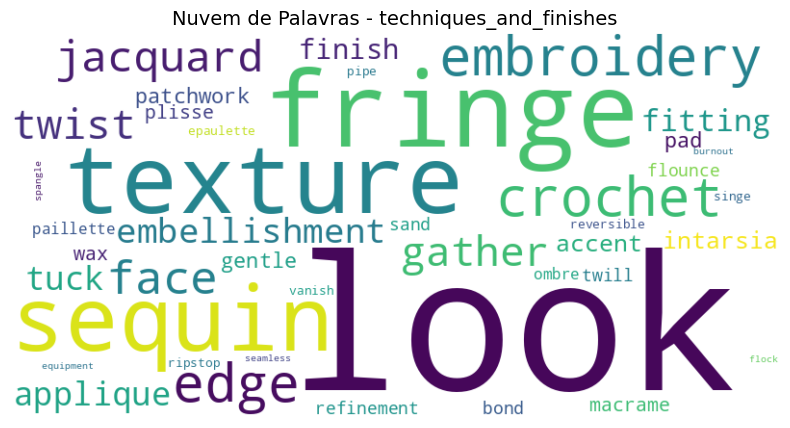

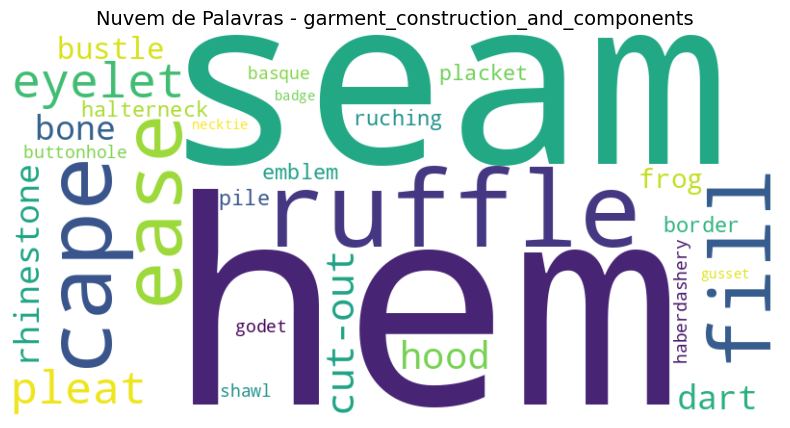

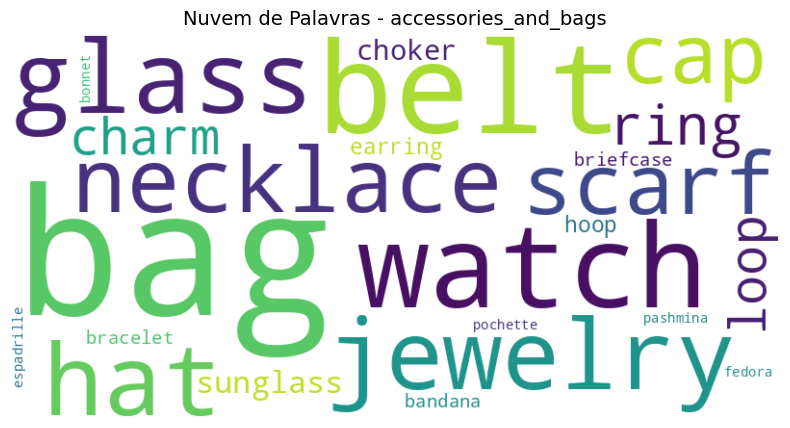

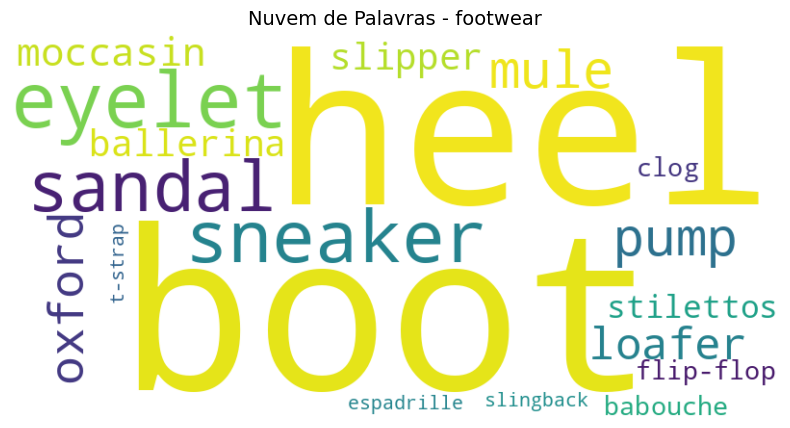

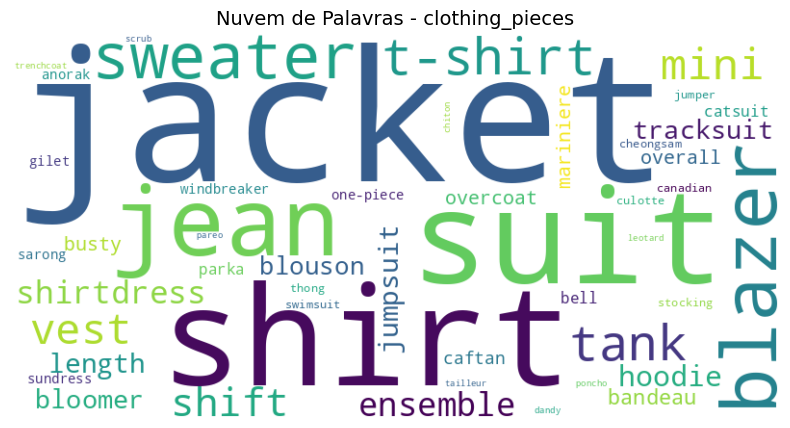

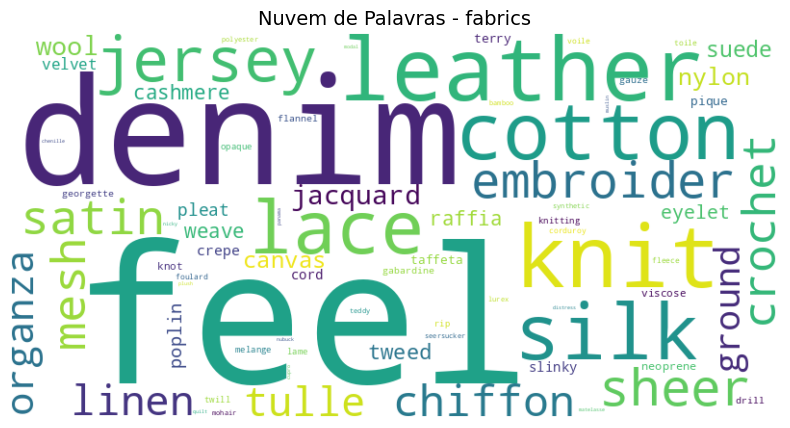

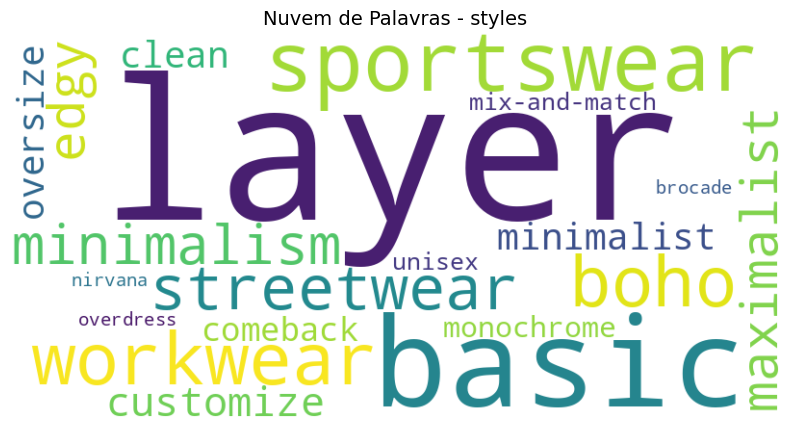

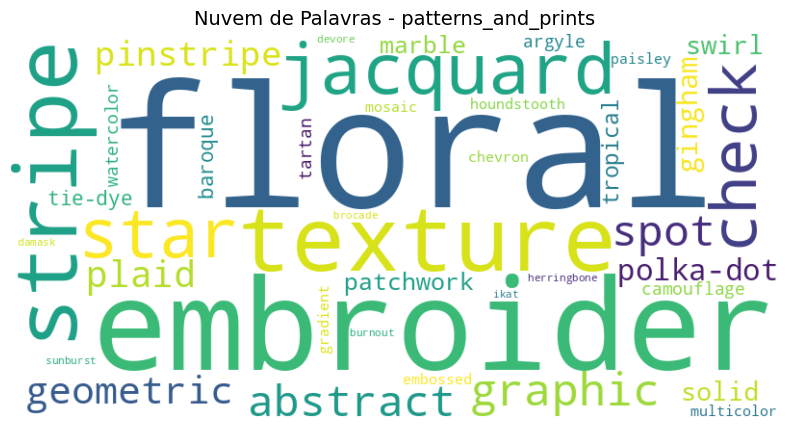

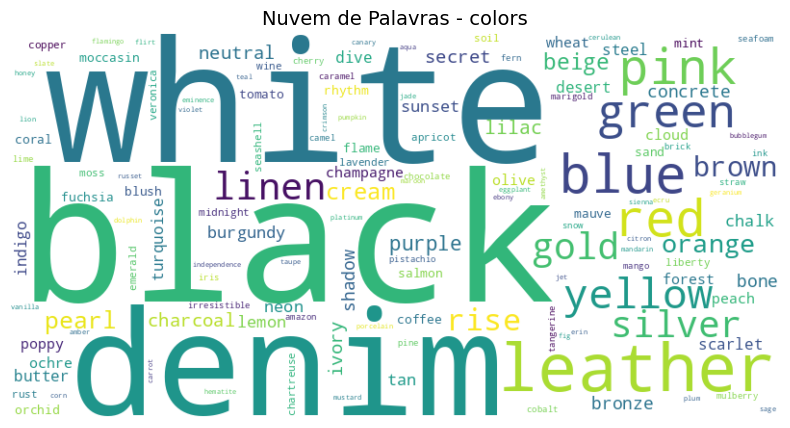

In [3]:
# 📌 **2️⃣ Função de Pré-Processamento**
def clean_text(text):
    """Limpa o texto sem remover hífens"""
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r"\d+", "", text)  # Remove números
    text = re.sub(r"[^\w\s-]", "", text)  # Mantém apenas letras, números e hífens
    text = re.sub(r"\s+", " ", text).strip()  # Remove espaços extras
    return text

def lemmatize_article(text):
    """Lematiza o texto mantendo palavras com hífen e filtra apenas substantivos"""
    doc = nlp(text)
    return [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct
    ]

# 📌 **3️⃣ Aplicar pré-processamento**
preprocessed_articles = [" ".join(lemmatize_article(clean_text(article))) for article in articles]

# 📌 **4️⃣ Processar Palavras do Pacote Fashion Words**
fashion_words_processed_by_category = {
    category: set(" ".join(lemmatize_article(clean_text(word))) for word in words)
    for category, words in fashion_words.words.items()
}

fashion_words_processed_set = set(
    word for category in fashion_words_processed_by_category.values() for word in category
)

# 📌 **5️⃣ Contagem de Frequências**
word_counts = Counter(" ".join(preprocessed_articles).split())

freq_por_categoria = {
    categoria: {
        palavra: word_counts.get(palavra, 0) for palavra in palavras
    }
    for categoria, palavras in fashion_words_processed_by_category.items()
}

# 📌 Criar DataFrame de Frequências
df_frequencias = pd.concat([
    pd.DataFrame(list(palavras_freq.items()), columns=["Palavra", "Frequência"]).assign(Categoria=categoria)
    for categoria, palavras_freq in freq_por_categoria.items()
]).sort_values(by=["Categoria", "Frequência"], ascending=[True, False])

# 📌 **6️⃣ Gerar N-Gramas (Bigramas e Trigramas)**
def generate_ngrams(corpus, n, top_k=20, filter_words=None):
    """Gera n-gramas (bigramas/trigramas) com opção de filtro"""
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))

    if filter_words:
        ngram_counts = {ngram: count for ngram, count in ngram_counts.items() if any(word in filter_words for word in ngram.split())}

    return Counter(ngram_counts).most_common(top_k)

# 📌 **Bigramas e Trigramas Gerais**
general_bigrams = generate_ngrams(preprocessed_articles, 2)
general_trigrams = generate_ngrams(preprocessed_articles, 3)

# 📌 **Bigramas e Trigramas de Moda**
fashion_bigrams = generate_ngrams(preprocessed_articles, 2, filter_words=fashion_words_processed_set)
fashion_trigrams = generate_ngrams(preprocessed_articles, 3, filter_words=fashion_words_processed_set)

# 📌 **Bigramas e Trigramas por Categoria**
bigrams_por_categoria = {
    categoria: generate_ngrams(preprocessed_articles, 2, filter_words=palavras)
    for categoria, palavras in fashion_words_processed_by_category.items()
}

trigrams_por_categoria = {
    categoria: generate_ngrams(preprocessed_articles, 3, filter_words=palavras)
    for categoria, palavras in fashion_words_processed_by_category.items()
}

# 📌 **7️⃣ Gerar Gráficos e Nuvem de Palavras**
def plot_ngrams(ngrams, title, color):
    """Plota os n-gramas"""
    df = pd.DataFrame(ngrams, columns=["N-Grama", "Frequência"])
    plt.figure(figsize=(10, 5))
    plt.barh(df["N-Grama"], df["Frequência"], color=color)
    plt.xlabel("Frequência", fontsize=14)
    plt.ylabel("N-Gramas", fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()
    plt.show()

# 📌 **Gerar Nuvem de Palavras por Categoria**
def criar_nuvem_palavras(freq_dict, categoria):
    """Gera nuvem de palavras baseada na frequência"""
    if not freq_dict:
        print(f"⚠️ Nenhuma palavra encontrada para {categoria}")
        return
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuvem de Palavras - {categoria}", fontsize=14)
    plt.show()

# 📌 **Exibir Gráficos**
print("\n📌 Gerando gráficos...")
plot_ngrams(general_bigrams, "Top 20 Bigramas Gerais", "#C0FF00")
plot_ngrams(fashion_bigrams, "Top 20 Bigramas de Moda", "#FF007F")
plot_ngrams(general_trigrams, "Top 20 Trigramas Gerais", "#C0FF00")
plot_ngrams(fashion_trigrams, "Top 20 Trigramas de Moda", "#FF007F")

# 📌 **Bigramas por Categoria**
for categoria, bigramas in bigrams_por_categoria.items():
    print(f"\n📌 Bigramas para {categoria}:")
    plot_ngrams(bigramas, f"Top 20 Bigramas - {categoria}", "#FF007F")

# 📌 **Trigramas por Categoria**
for categoria, trigramas in trigrams_por_categoria.items():
    print(f"\n📌 Trigramas para {categoria}:")
    plot_ngrams(trigramas, f"Top 20 Trigramas - {categoria}", "#C0FF00")

# 📌 **Nuvem de Palavras por Categoria**
for categoria, palavras_freq in freq_por_categoria.items():
    criar_nuvem_palavras(palavras_freq, categoria)
